### Imports

In [41]:
import os
import sys
import pandas as pd 
import numpy as np 
from random import sample
import random
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#make more rows and columns visible in the output console
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 600)
pd.set_option('display.width', 1000)
np.set_printoptions(threshold=sys.maxsize)
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster, ward, dendrogram

In [42]:
#importing functions from our custom  helper file

In [43]:
sys.path.append('./my_module')
from helper import get_distances

### Load the Data

In [44]:
df_unstacked = pd.read_csv('unstacked_udacity.csv',dtype =  {'retail_prod_id': np.int32})

In [45]:
df_unstacked.head()

,zrep,item_retail_id,retailer,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312
0,1,1_0,0,13274,12712,13650,16288,15086,10864,13492,10964,11810,14532,15656,14268,8464,11646,13650,12554,13190,16222,17508,13106,15766,13338,11940,12906,15414,16682,12444,14438,12044,11382,12008,15416,16202,12748,15082,12852,11548,11090,13264,13824,11656,12010,9924,9562,10648,13362,11488,11706,14306,11784,11990,14222,17820,19346,15146,17522,13974,13156,14492,18292,19328,14128,16128,13324,11894,13704,17890,18208,14512,17856,14092,13352,14674,19040,20320,15036,17674,14696,13218,14104,18274,18208,14018,16686,13138,12288,13066,16690,18814,13974,16674,13382,12474,12514,14908,16780,12702,14418,12194,11302,11864,14658,15332,11398,13962,11462,10460,11780,14008,15684,12324,14244,11586,10770,11456,13778,14436,11548,13422,11838,11390,10894,12754,14058,11092,13050,11252,10206,11448,13972,14896,11152,17358,5346,12,3122,11032,12308,8562,14744,10790,3790,14690,17684,19496,15408,16540,15066,14046,13976,18048,20536,15980,15822,13596,12848,14172,18296,19508,15950,16722,13390,12652,14480,18598,21190,16210,17480,14304,13166,14250,18856,20606,16512,17234,14270,12494,14328,17838,20066,13782,16562,13802,12252,12020,13812,16082,11344,13260,10750,9974,10688,14512,16040,11300,13258,11128,10010,11326,16302,19084,12902,14686,12688,12616,14894,18156,19730,14040,17698,15840,19006,34748,41520,49300,34608,48780,45122,56372,78432,48738,36060,15974,31116,25022,25628,24514,28974,26472,15950,25300,25112,25620,26922,30412,26984,15386,26216,24132,25996,30640,27942,24858,2608,21756,26206,25958,27204,26446,23504,14184,22404,22086,22198,24256,25874,23558,14648,22884,21892,22494,25302,26830,24732,14994,23474,22442,22962,25472,22350,20204,15056,21380,20084,20198,20536,22928,20900,12960,20610,18384,16292,19556,24444,21694,12566,14100,17432,15836,17422,19402,18562,12196,17292,15876,17406,21304,24016,23138,14636,20580,18514,18642,21160,22278,20002,12108,17344,15670,14902,17392,20420,19052
1,1,1_1,1,1876,1774,1700,1550,1346,1184,1520,1486,3786,3438,3052,2718,2148,3212,3864,3880,3692,3506,3138,2816,4312,4346,4390,4450,3652,3394,3080,4630,2850,1580,1502,1322,970,968,1440,1300,1242,1156,1130,818,832,1312,1294,1364,1136,960,1026,862,1340,1694,5376,5428,5024,4282,3766,5894,5710,5438,5342,4440,4144,3762,5358,5422,5280,4850,4350,3966,3606,5254,3190,1294,1152,1036,914,828,1354,1196,1154,924,980,990,770,1236,1226,1182,1252,988,930,768,1236,1540,4556,4290,3726,3626,3098,4740,4740,4764,4228,3564,3266,2982,4572,4708,4558,4206,3398,3436,3046,4838,2754,1328,1332,986,1010,876,1328,1102,1196,1122,912,868,780,1162,998,970,928,894,764,758,1096,802,0,610,1124,2088,1990,2786,2432,1900,3544,3550,3422,2908,4322,4402,4698,4638,3956,3446,2982,4288,4146,4438,4506,3802,3626,3132,4416,4488,4080,3914,3422,3126,3038,4372,4100,3848,3744,3296,3088,2918,4268,2834,1552,1394,1162,1174,944,1562,1318,1318,1226,1006,1064,942,1338,1328,1194,1196,1084,1066,884,1

### Introduction to the dataset

This is a sales dataset that has been provided as to me as a sensitive commercial dataset and hence has been anonymized and unstacked into the wide format  prior to loading into this project workbook ( as otherwise it was too larget to handle by github and udacity reviewwers ).

all the numeric values  have been changed, as well as categorical columns (('zrep',  'retailer') have been re-coded into numerical values, hence we will be refering to these newly coded values when speaking about retailers etc.

item_retail_id is a combined field that has zrep+retailer concatenated into one. I have created this in order to have a field that could be used later in the algorithm implementation as it provides more granularity than just zrep or retailer alone

This dataset is  a set of time series for sales quantity, recorded every day for 313 days.

It might be useful to explain some of the granularity level relationship of this dataset :

* zrep(item)  is  retailer agnostic, so we can see repeated zreps across multiple retailers
* dates are encoded with numerical values, but the starting day - day 0 is 2019-08-13 for our future refence
* values used in day encoded columns are sales quantity in units



### Problem statement - Clustering time series

In this analysis we will be using clustering in order to try and group the items that have similar structure , which allows us to be prepared to handle items in same groups in a similar way in the future, if for example,  we will have a business request to allocate a new product into a "category" of already existing products to see how it will behave in the future, clustering is a good way of helping with that business problem. 

### Basic information about the dataset

Let's see how large the dataset it and get some basic statistics to get to know it better

In [46]:
# How large is our dataset
df_unstacked.shape

(221, 316)

In [47]:
# It is a rather large one, what are the dattypes?
df_unstacked.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Columns: 316 entries, zrep to 312
dtypes: int64(315), object(1)
memory usage: 545.7+ KB


Most of the columns are  numeric, but the memory usage of the dataset is rather impressive, 
we will need to trim it down to only the columns that we need to work with. First let's have a look at the basic stats to see if there is anythinng out of norm

For the purpose of this analysis we got rid of the negative sales_qty values prior to loading the dataset here, as sometimes , in the business context , transactions with negative sales valuee might mean that a certain correction was being made, or a reversal of an earlier transaction, but as we do not really have a context here we will omit these records. In the real life business situation we should always investigate these where possible and decided what to do with them. Sometimes it might be an option to convert these to '0', but only if the context allows.

In [48]:
df_unstacked.isna().sum()

zrep              0
item_retail_id    0
retailer          0
0                 0
1                 0
2                 0
3                 0
4                 0
5                 0
6                 0
7                 0
8                 0
9                 0
10                0
11                0
12                0
13                0
14                0
15                0
16                0
17                0
18                0
19                0
20                0
21                0
22                0
23                0
24                0
25                0
26                0
27                0
28                0
29                0
30                0
31                0
32                0
33                0
34                0
35                0
36                0
37                0
38                0
39                0
40                0
41                0
42                0
43                0
44                0
45                0
46                0


As a final quick check, let's explore the a little more around levels of granularity of this dataset and how it is structured before we move to pre-processing

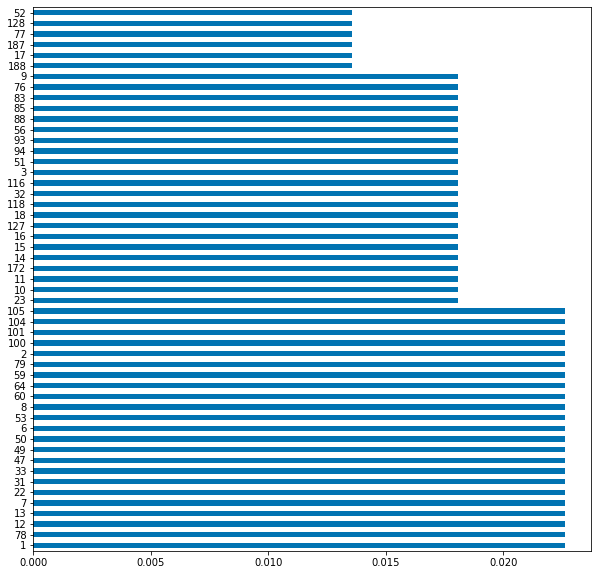

In [49]:
fig = plt.figure(figsize=(10,10))
df_unstacked.zrep.value_counts(normalize=True).plot(kind='barh')

In [50]:
df_unstacked.retailer.value_counts(normalize=True)

3    0.230769
2    0.226244
0    0.226244
1    0.208145
4    0.108597
Name: retailer, dtype: float64

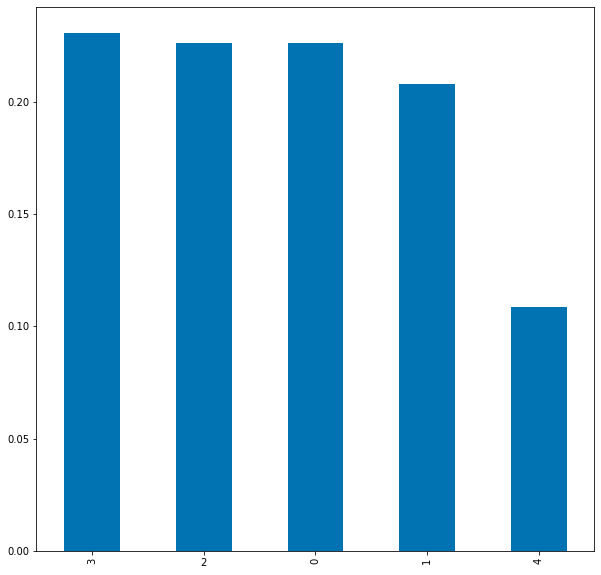

In [51]:
fig = plt.figure(figsize=(10,10))
plt.xticks(np.arange(min(df_unstacked.retailer.value_counts(normalize=True)), max(df_unstacked.retailer.value_counts(normalize=True))))
df_unstacked.retailer.value_counts(normalize=True).plot(kind='bar')

We see quite well distributed zreps and retailers 

### Exploration of time series

Let's plot the timeseries on different levels of granurality to examine them visually as a first step

In [52]:
series = df_unstacked.iloc[:,3:].columns.tolist()

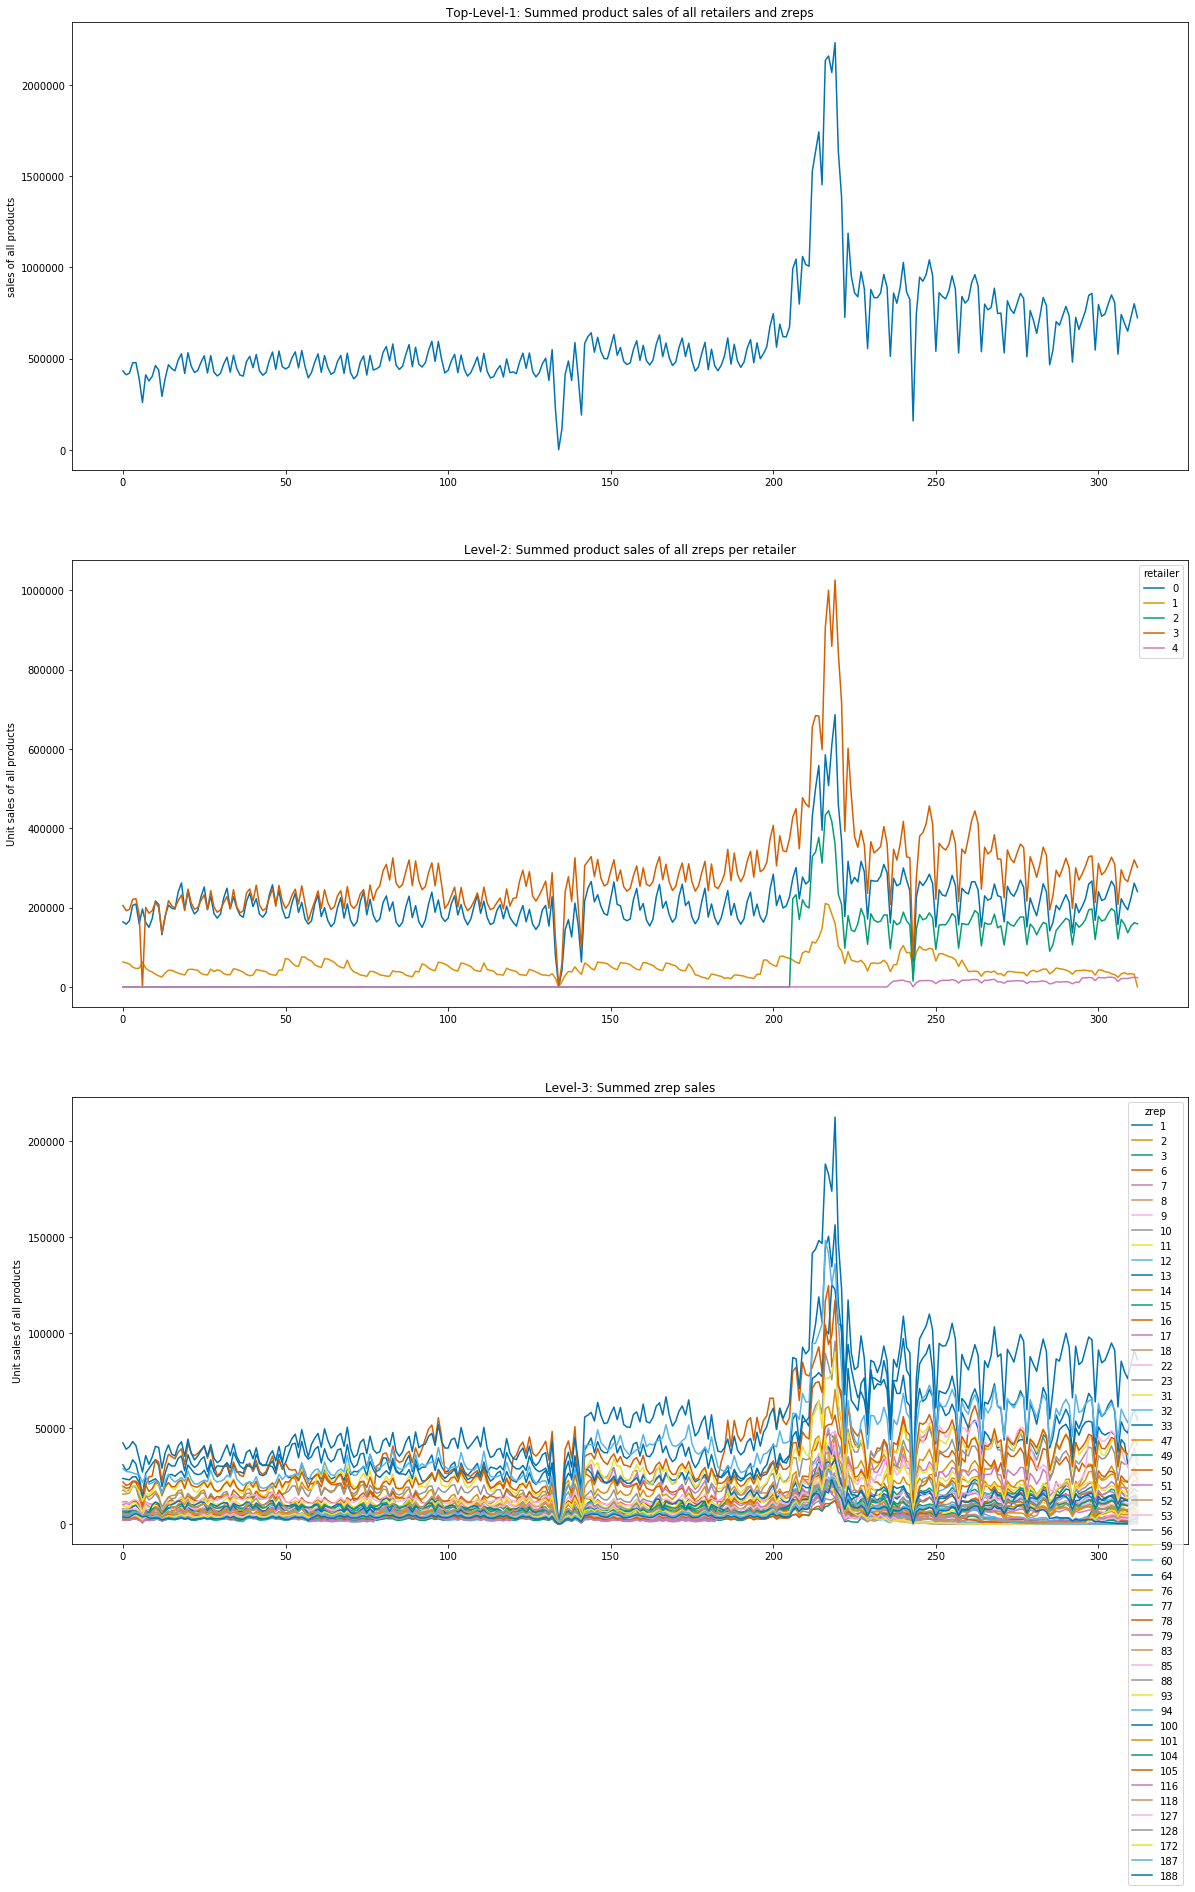

In [53]:
sns.set_palette("colorblind")

fig, ax = plt.subplots(3,1,figsize=(20,28))

df_unstacked[series].sum().plot(ax=ax[0])
ax[0].set_title("Top-Level-1: Summed product sales of all retailers and zreps")
ax[0].set_ylabel("sales of all products");

df_unstacked.groupby("retailer")[series].sum().transpose().plot(ax=ax[1])
ax[1].set_title("Level-2: Summed product sales of all zreps per retailer");
ax[1].set_ylabel("Unit sales of all products");

df_unstacked.groupby("zrep")[series].sum().transpose().plot(ax=ax[2])
ax[2].set_title("Level-3: Summed zrep sales")
ax[2].set_ylabel("Unit sales of all products");

* We see that there are periodic patterns in these series and it is also more visually clear now how these aggregation levels work in the dataset as they also follow the same shape of the series on all 3 levels.
* It is also interesting to iobserve that around days 215-220 we see a massive upwards spike in the series for all of the zreps and retailers. Let's have a look where these days fall in the calendar

In [54]:
startdate = '2019-08-13'
pd.to_datetime(startdate) + pd.DateOffset(days=220)

Timestamp('2020-03-20 00:00:00')

Most likely, What we see in the graphs is a clear demonstration of the effect of Covid 19 on the sales of this business to it's retailers as March is around the time where strict lockdown and impulsive stockpiling were a common occurence within several countries around the globe.

Now, Let's use some helper functions to help us slice the time series on zreps , retail_prod_id (combination of zrep and retailer) and retailer in more detail 

In [55]:
df_unstacked.head(3)

,zrep,item_retail_id,retailer,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312
0,1,1_0,0,13274,12712,13650,16288,15086,10864,13492,10964,11810,14532,15656,14268,8464,11646,13650,12554,13190,16222,17508,13106,15766,13338,11940,12906,15414,16682,12444,14438,12044,11382,12008,15416,16202,12748,15082,12852,11548,11090,13264,13824,11656,12010,9924,9562,10648,13362,11488,11706,14306,11784,11990,14222,17820,19346,15146,17522,13974,13156,14492,18292,19328,14128,16128,13324,11894,13704,17890,18208,14512,17856,14092,13352,14674,19040,20320,15036,17674,14696,13218,14104,18274,18208,14018,16686,13138,12288,13066,16690,18814,13974,16674,13382,12474,12514,14908,16780,12702,14418,12194,11302,11864,14658,15332,11398,13962,11462,10460,11780,14008,15684,12324,14244,11586,10770,11456,13778,14436,11548,13422,11838,11390,10894,12754,14058,11092,13050,11252,10206,11448,13972,14896,11152,17358,5346,12,3122,11032,12308,8562,14744,10790,3790,14690,17684,19496,15408,16540,15066,14046,13976,18048,20536,15980,15822,13596,12848,14172,18296,19508,15950,16722,13390,12652,14480,18598,21190,16210,17480,14304,13166,14250,18856,20606,16512,17234,14270,12494,14328,17838,20066,13782,16562,13802,12252,12020,13812,16082,11344,13260,10750,9974,10688,14512,16040,11300,13258,11128,10010,11326,16302,19084,12902,14686,12688,12616,14894,18156,19730,14040,17698,15840,19006,34748,41520,49300,34608,48780,45122,56372,78432,48738,36060,15974,31116,25022,25628,24514,28974,26472,15950,25300,25112,25620,26922,30412,26984,15386,26216,24132,25996,30640,27942,24858,2608,21756,26206,25958,27204,26446,23504,14184,22404,22086,22198,24256,25874,23558,14648,22884,21892,22494,25302,26830,24732,14994,23474,22442,22962,25472,22350,20204,15056,21380,20084,20198,20536,22928,20900,12960,20610,18384,16292,19556,24444,21694,12566,14100,17432,15836,17422,19402,18562,12196,17292,15876,17406,21304,24016,23138,14636,20580,18514,18642,21160,22278,20002,12108,17344,15670,14902,17392,20420,19052
1,1,1_1,1,1876,1774,1700,1550,1346,1184,1520,1486,3786,3438,3052,2718,2148,3212,3864,3880,3692,3506,3138,2816,4312,4346,4390,4450,3652,3394,3080,4630,2850,1580,1502,1322,970,968,1440,1300,1242,1156,1130,818,832,1312,1294,1364,1136,960,1026,862,1340,1694,5376,5428,5024,4282,3766,5894,5710,5438,5342,4440,4144,3762,5358,5422,5280,4850,4350,3966,3606,5254,3190,1294,1152,1036,914,828,1354,1196,1154,924,980,990,770,1236,1226,1182,1252,988,930,768,1236,1540,4556,4290,3726,3626,3098,4740,4740,4764,4228,3564,3266,2982,4572,4708,4558,4206,3398,3436,3046,4838,2754,1328,1332,986,1010,876,1328,1102,1196,1122,912,868,780,1162,998,970,928,894,764,758,1096,802,0,610,1124,2088,1990,2786,2432,1900,3544,3550,3422,2908,4322,4402,4698,4638,3956,3446,2982,4288,4146,4438,4506,3802,3626,3132,4416,4488,4080,3914,3422,3126,3038,4372,4100,3848,3744,3296,3088,2918,4268,2834,1552,1394,1162,1174,944,1562,1318,1318,1226,1006,1064,942,1338,1328,1194,1196,1084,1066,884,1

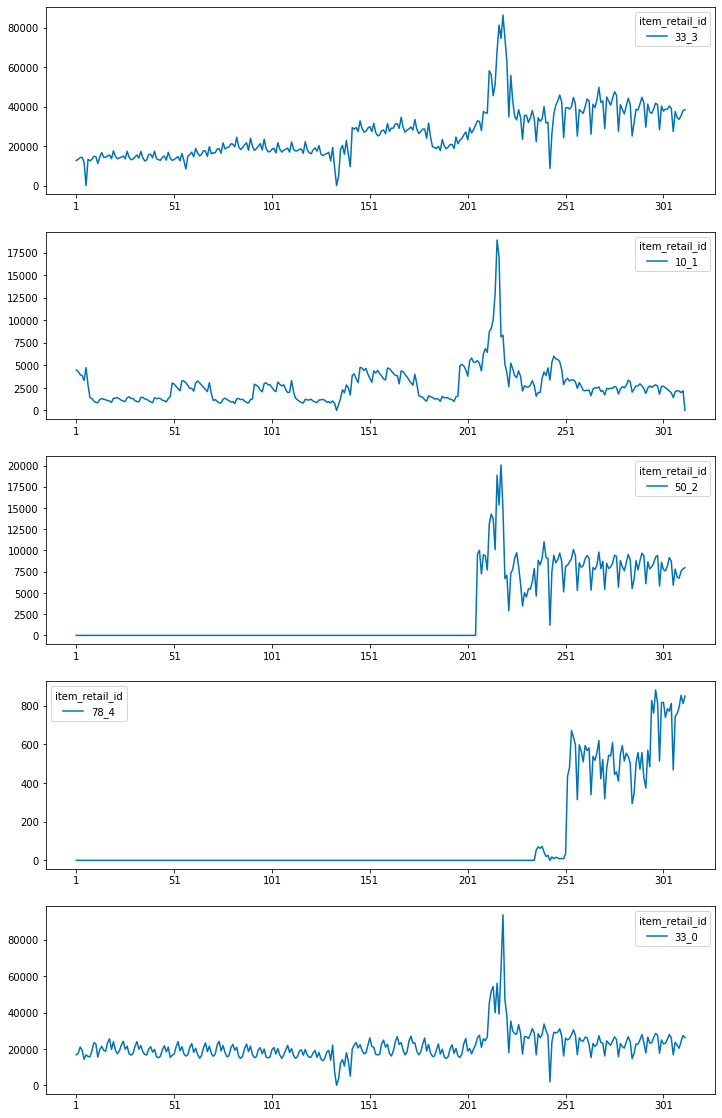

In [56]:
def series_ids(ids:str) -> pd.DataFrame:
    """
    Get a daily time series for a single retailer's item number
    """
    return df_unstacked.loc[df_unstacked.item_retail_id == ids].set_index('item_retail_id').iloc[:,3:].T

fig, axes = plt.subplots(nrows = 5, figsize = (12,20))
ids = df_unstacked["item_retail_id"].sample(n = 5, random_state = 1)
for i in range(len(ids)):
    series_ids(ids.iloc[i]).plot(ax = axes[i])

#### Note 
* We see some clear differences in the series shapes - there are visibly diffrent trends and time series shapes look different for the selected product-retailer combinations
* Plus the scale is different. The 4th  series has the most contrast , series 1,2,3 and 5 operating in the thousands a day and the former between 0 and 800 .
* Also, we see that some series only really "pick up" later after day 201 as on 3rd and 4th series, which is really interesting. Could this mean that this combination of zrep and retailer was not previously sold and seems to have been introduced thanks to the pandemic?

To avoid dealing with very noisy series, I'll bin sales by week, which will remove weekly seasonality and lead the number of sales per time unit to be less volitile.

In [57]:
"""
Time series for particular items are quite noisy on a daily level. 
Provide the ability to bin sales (for examply - to a weekly bin) for more stable plots
"""
def series_weekly(ids:str, bin_every:int = 7) -> pd.DataFrame:
    """
    Get the sales for an id, grouped by a fixed interval (default 7 - weekly)
    """
    t = series_ids(ids).reset_index()
    t["index"] = t.index.map(lambda x: x - (x % bin_every))
    t.columns = pd.Index(["day", "sales"])
    return t.groupby("day")\
        .agg({"sales":"sum"})

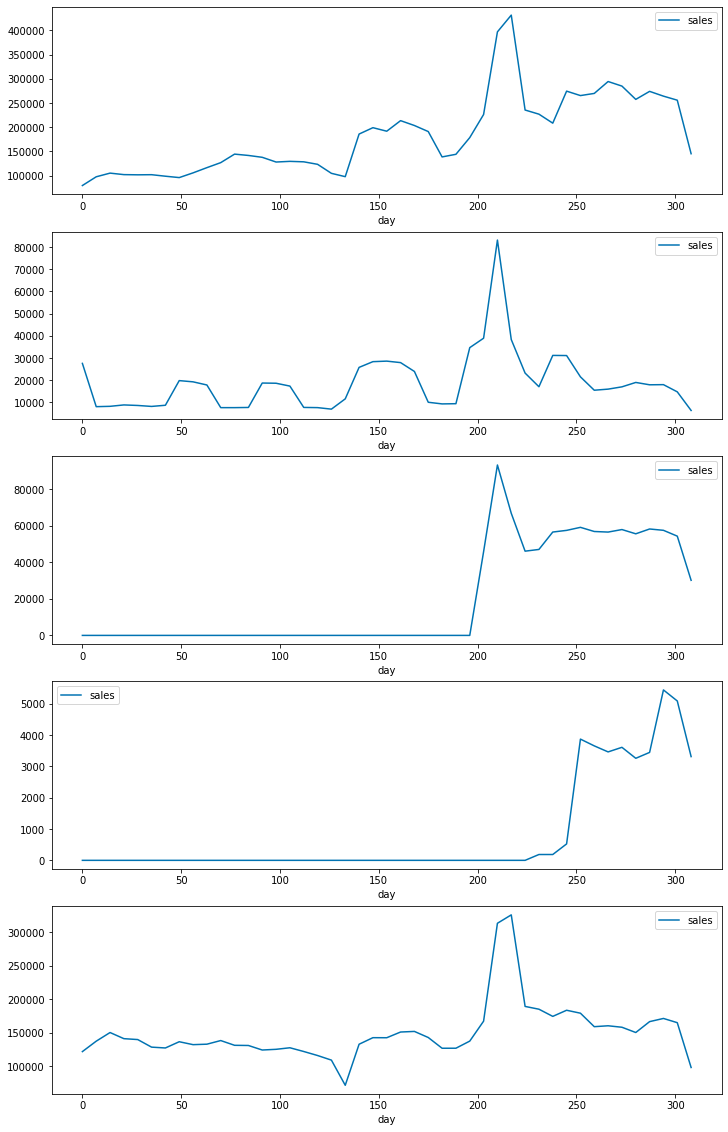

In [58]:
"""
Time series for particular items are quite noisy on a daily level. 
Provide the ability to bin sales (for examply - to a weekly bin) for more stable plots
"""
def series_weekly(ids:str, bin_every:int = 7) -> pd.DataFrame:
    """
    Get the sales for an id, grouped by a fixed interval (default 7 - weekly)
    """
    t = series_ids(ids).reset_index()
    t["index"] = t.index.map(lambda x: x - (x % bin_every))
    t.columns = pd.Index(["day", "sales"])
    return t.groupby("day")\
        .agg({"sales":"sum"})
# bin the items by week and plot again
fig, axes = plt.subplots(nrows = 5, figsize = (12,20))
ids = df_unstacked["item_retail_id"].sample(n = 5, random_state = 1)
for i in range(len(ids)):
    series_weekly(ids.iloc[i], bin_every = 7).plot(ax = axes[i])

Now that we got rid of the weekly cycle, we see similarly to before that some sales only start after a certain day and that could be a complication that we might need to deal with outside of this analysis , for example introducing DMT (dynamic time wrapping) as a way of "clipping" the start of the series that had no sales before and only use the data after the sales "kicked in" and >0

In [59]:
# create a  lookup table for fast plotting by item
daily_sales_item_lookup = df_unstacked[["zrep"] + list(df_unstacked.columns[3:])]\
    .melt(id_vars = "zrep")\
    .groupby("zrep variable".split())\
    .agg({"value":"sum"})

def series_from_item(zrep:str) -> pd.DataFrame:
    return daily_sales_item_lookup.loc[zrep]

In [60]:
def series_weekly_zrep(zreps:str, bin_every:int = 7) -> pd.DataFrame:
    """
    Get the sales for an item (across stores), grouped by a fixed interval (default 7 - weekly)
    """
    t = series_from_item(zreps).reset_index()
    t["variable"] = t.index.map(lambda x: x - (x % bin_every))
    return t.groupby("variable")\
        .agg({"value":"sum"})

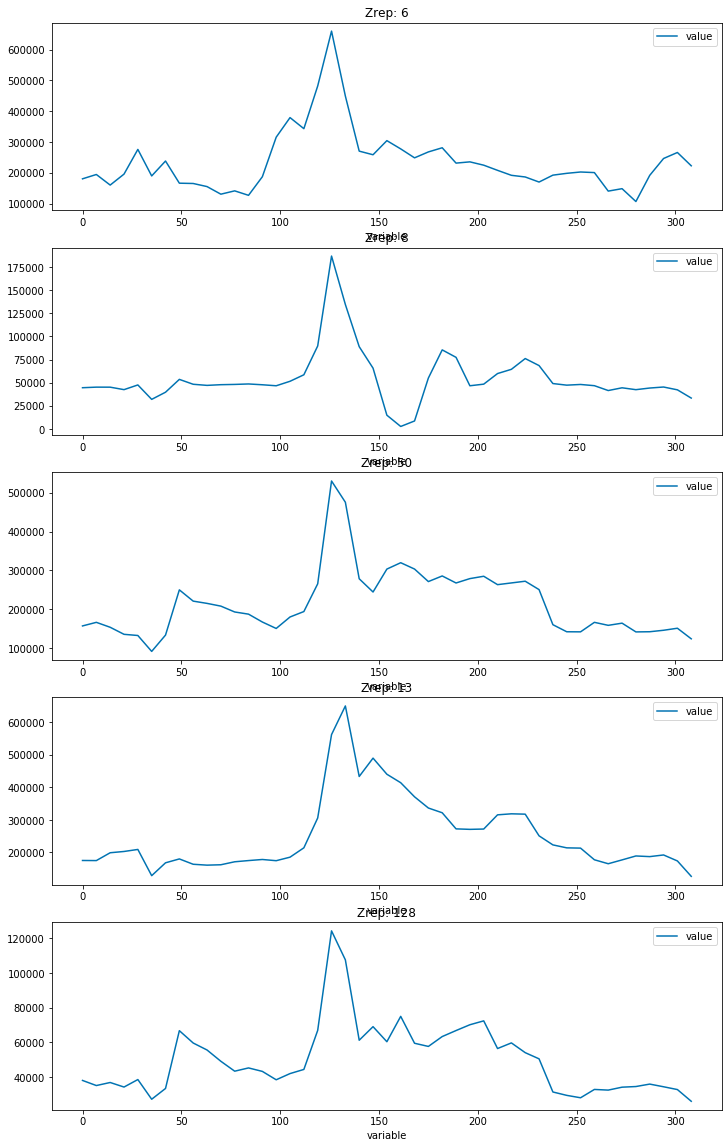

In [61]:
fig, axes = plt.subplots(nrows = 5, figsize = (12,20))
random.seed(2)
zreps = sample(list(df_unstacked["zrep"].unique()), 5)
for i in range(len(zreps)):
    series_weekly_zrep(zreps[i], bin_every = 7).plot(ax = axes[i])
    axes[i].set_title("Zrep: %s" % zreps[i])

When plotting 5 random zreps we do not see the same variability and later series start as we did with the zrep+retailer combination, as zrep is an identifier that is not tied to the retailer, it won't capture that a certain retailer did not have the product introduced until a certain day, whereas this is what we saw above with the zrep+retailer combination based plots

Finally , plotting on retailer level

In [63]:
# Create a  lookup table for fast plotting by retailer
daily_sales_retailer_lookup = df_unstacked[["retailer"] + list(df_unstacked.columns[3:])]\
    .melt(id_vars = "retailer")\
    .groupby("retailer variable".split())\
    .agg({"value":"sum"})
def series_from_ret(ret:str) -> pd.DataFrame:
    return daily_sales_retailer_lookup.loc[ret]

In [64]:
def series_weekly_ret(ret:str, bin_every:int = 7) -> pd.DataFrame:
    """
    Get the sales for a department, grouped by a fixed interval (default 7 - weekly)
    """
    t = series_from_ret(ret).reset_index()
    t["variable"] = t.index.map(lambda x: x - (x % bin_every))
    return t.groupby("variable")\
        .agg({"value":"sum"})

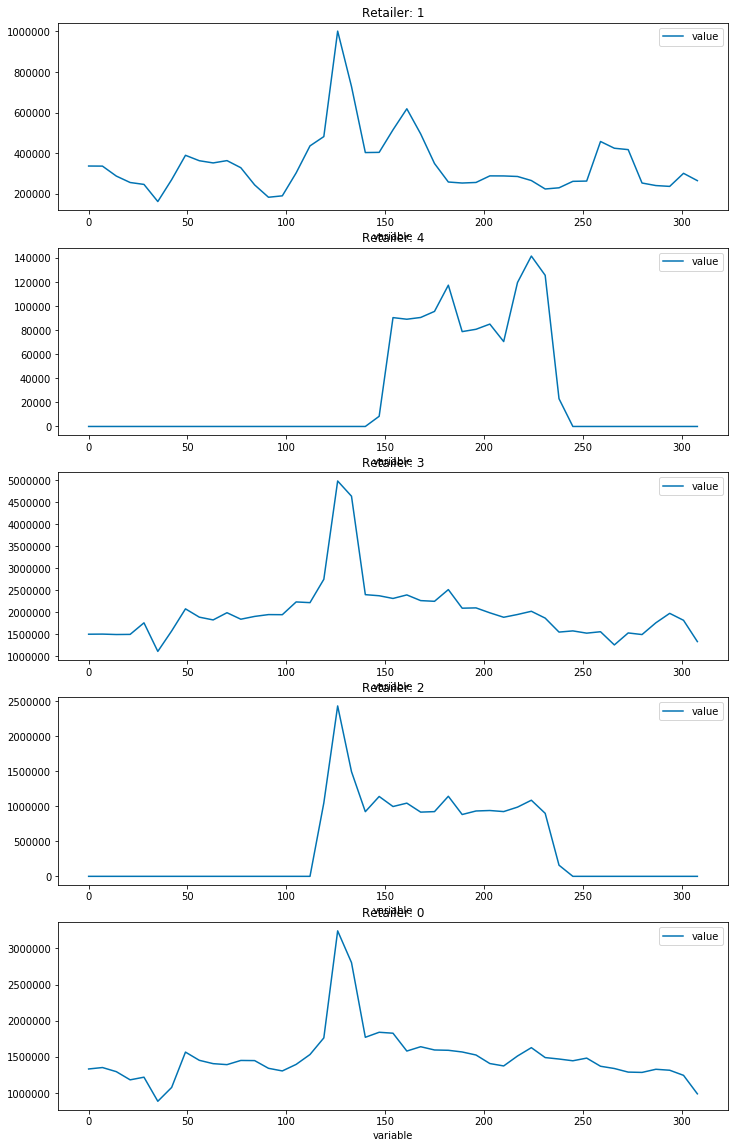

In [65]:
fig, axes = plt.subplots(nrows = 5, figsize = (12,20))
random.seed(3)
retailers = sample(list(df_unstacked["retailer"].unique()), 5)
for i in range(len(retailers)):
    series_weekly_ret(retailers[i], bin_every = 7).plot(ax = axes[i])
    axes[i].set_title("Retailer: %s" % retailers[i])

We see that for retailers 4 and 2 we actually do not capture any sales until after day 100. I wonder if this is the quirk of the data, as we would expect all the retailers to have data consistently for most days

#### Clustering on a item_retail_id (zrep+retailer) level

It probably makes sense to cluster on a level of series that doesn't have too much noise , but is still useful.
I might settle on this level because retailer level is too broad and we only have a handful of them.

Clustering on levels lower than that would probably introduce too much noise. Although I acknowledge the fact that zrep/item+store combination might bring some extra level of information , I think zrep+retailer level could be a good way to start.We might also try clustering on zrep level alone, to see how that would change the clusters quality. 

#### Standardisation
We are iltimately interested in the shape of the time -series, not clustering items that are in high demand vs those that are not, and because some of our items are more popular than others, we might want to "standardise" the series in a way

Below we will create views/visualisations in parallel for both the zrep+retailer and zrep only level in order to try clustering on both separately to see which creates more defined clusters

In [66]:
# create a  lookup table for fast plotting by item
daily_sales_itemretail_lookup = df_unstacked[["item_retail_id"] + list(df_unstacked.columns[3:])]\
    .melt(id_vars = "item_retail_id")\
    .groupby("item_retail_id variable".split())\
    .agg({"value":"sum"})

In [67]:
# create a  lookup table for fast plotting by item
daily_sales_item_lookup = df_unstacked[["zrep"] + list(df_unstacked.columns[3:])]\
    .melt(id_vars = "zrep")\
    .groupby("zrep variable".split())\
    .agg({"value":"sum"})

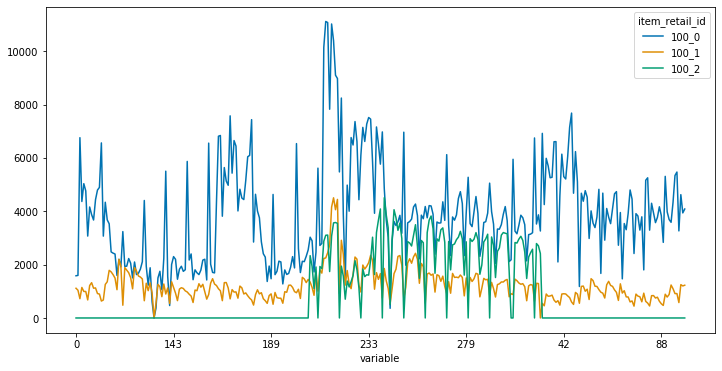

In [68]:
daily_sales_itemretail_lookup.pivot_table(index = "variable", columns = "item_retail_id", values = "value")\
    .iloc[:,:3]\
    .plot(figsize = (12,6))

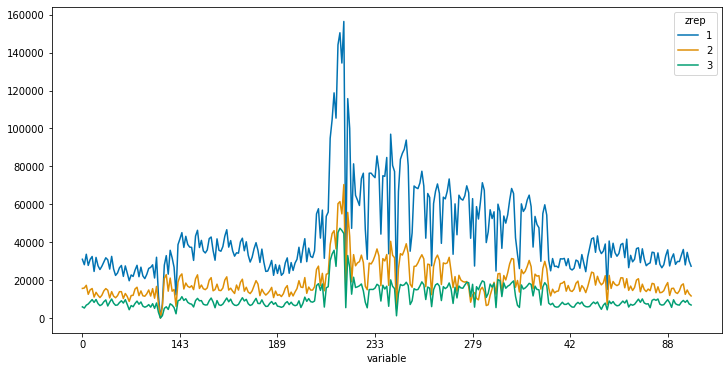

In [69]:
# plotting 10 series, for demonstration
daily_sales_item_lookup.pivot_table(index = "variable", columns = "zrep", values = "value")\
    .iloc[:,:3]\
    .plot(figsize = (12,6))

In [70]:
# Create a lookup table for scaled series
daily_sales_item_lookup_scaled = daily_sales_item_lookup\
    .pivot_table(index = "variable", columns = "zrep", values = "value").copy()
daily_sales_item_lookup_scaled = daily_sales_item_lookup_scaled.div(daily_sales_item_lookup_scaled.mean(axis = 0), axis = 1)

In [71]:
daily_sales_itemretail_lookup_scaled = daily_sales_itemretail_lookup\
    .pivot_table(index = "variable", columns = "item_retail_id", values = "value").copy()
daily_sales_itemretail_lookup_scaled = daily_sales_itemretail_lookup_scaled.div(daily_sales_itemretail_lookup_scaled.mean(axis = 0), axis = 1)

In [72]:
# bin by week
daily_sales_item_lookup_scaled_weekly = daily_sales_item_lookup_scaled.copy().reset_index()

In [73]:
daily_sales_itemretail_lookup_scaled = daily_sales_itemretail_lookup_scaled.copy().reset_index()

In [74]:
daily_sales_item_lookup_scaled_weekly["variable"] = daily_sales_item_lookup_scaled_weekly.variable.index.map(lambda x: x - (x % 7))

In [75]:
daily_sales_itemretail_lookup_scaled["variable"] = daily_sales_itemretail_lookup_scaled.variable.index.map(lambda x: x - (x % 7))

In [76]:
daily_sales_item_lookup_scaled_weekly = daily_sales_item_lookup_scaled_weekly.groupby("variable").mean()

In [77]:
daily_sales_itemretail_lookup_scaled = daily_sales_itemretail_lookup_scaled.groupby("variable").mean()

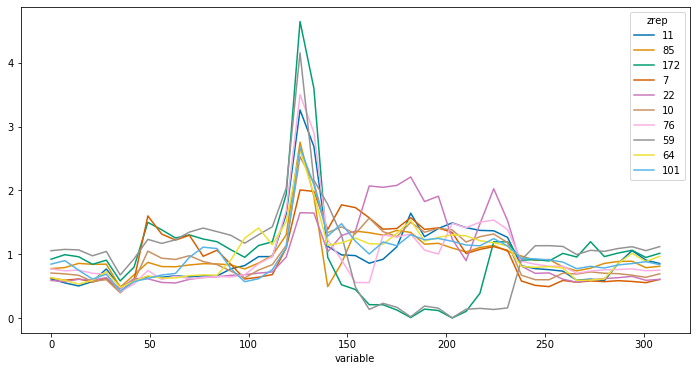

In [78]:
# plot those same series, but this time normalized by the series' means. 
random.seed(1)
daily_sales_item_lookup_scaled_weekly.iloc[:,random.sample(range(daily_sales_item_lookup_scaled_weekly.shape[1]),10)]\
    .plot(figsize = (12,6))

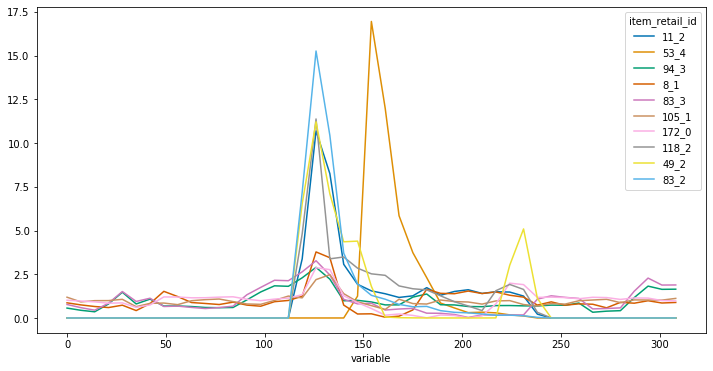

In [79]:
random.seed(1)
daily_sales_itemretail_lookup_scaled.iloc[:,random.sample(range(daily_sales_itemretail_lookup_scaled.shape[1]),10)]\
    .plot(figsize = (12,6))

Now that we have standerdised and brought the input data to the weekly level , we can focus on clustering based on series shape characteristics

#### Heirarchical clustering

The approach here that we will take first is called Hierarchical clustering, where each time-series would be viewed as a vector , all with same length , so we will be grouping series that behave in the similar way

##### Some pros and cons of Hierarchical Clustering
###### Pros
* No assumption of a particular number of clusters (i.e. k-means)

###### Cons

* Too slow for large data sets, O(𝑛2 log(𝑛))

##### How it works

1. Make each data point a cluster
 
2. Take the two closest clusters and make them one cluster

3. Repeat step 2 until there is only one cluster



We are starting with the zrep level only to see how it performs, and then we will try zrep+retailer and compare the two

In [80]:
# heirarchical clustering of scales weekly item sales. 
clf = AgglomerativeClustering(n_clusters=None, distance_threshold = 0).fit(daily_sales_item_lookup_scaled_weekly.T.values)

Let's get the Dendrogram for our clusters.
We can use a dendrogram to visualize  groupings and decide what is the optimal number of clusters.
How to do this?

1. Determine the largest vertical distance that doesn’t intersect any of the other clusters
2. Draw a horizontal line through the plot
3. Optimal number of clusters is equal to the number of vertical lines going through the horizontal line
4. Let's see what it is in our case

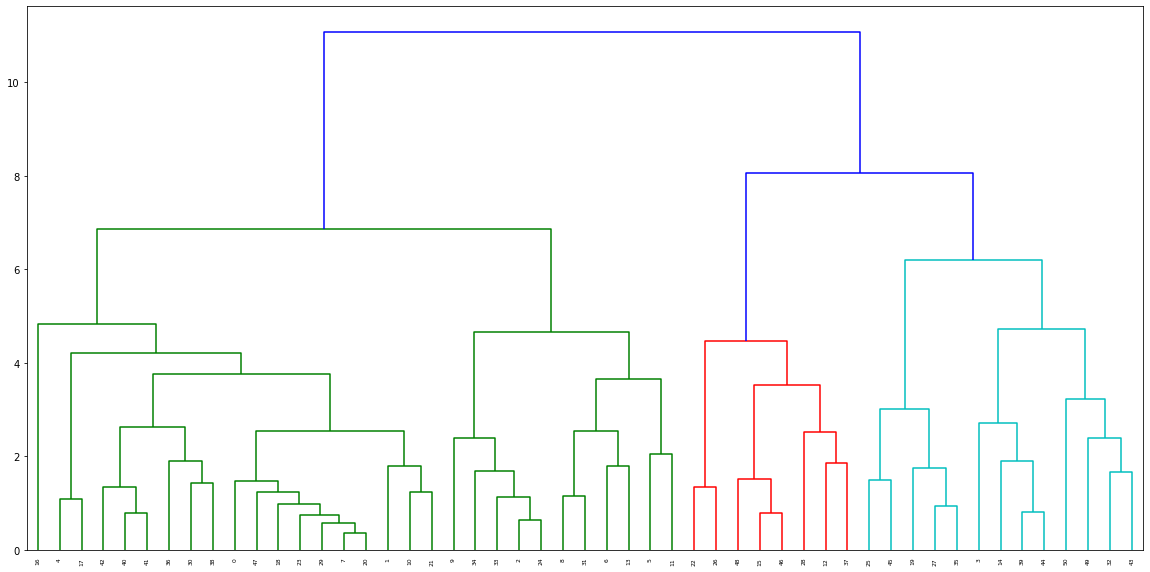

In [81]:
distance, weight = get_distances(daily_sales_item_lookup_scaled_weekly.T.values,clf)
linkage_matrix = np.column_stack([clf.children_, distance, weight]).astype(float)
plt.figure(figsize=(20,10))
Z= dendrogram(linkage_matrix)
plt.show()

To me this looks to be like the optimal number of clusters is only 2 clusters as if we draw a line at y=8 and y = 11 that is the longest vertical distance where we do not intersect with any other clusters. Let's have a look at the clusters members and what zreps do we really have in there

In [82]:
# extract clusters from dendogram
clusters = fcluster(linkage_matrix, 10, criterion='distance')
# create a lookup table for series in a given cluster
weekly_sales_item_lookup_scaled_clustered = daily_sales_item_lookup_scaled_weekly.T.reset_index()
weekly_sales_item_lookup_scaled_clustered["cluster"] = clusters
weekly_sales_item_lookup_scaled_clustered = weekly_sales_item_lookup_scaled_clustered.set_index("cluster zrep".split())\
    .sort_index()

Plot samples of series from clusters
To get a feel for what this clustering method has actually produced, we can plot a sample of series from each cluster, and try and see what is in common between them.

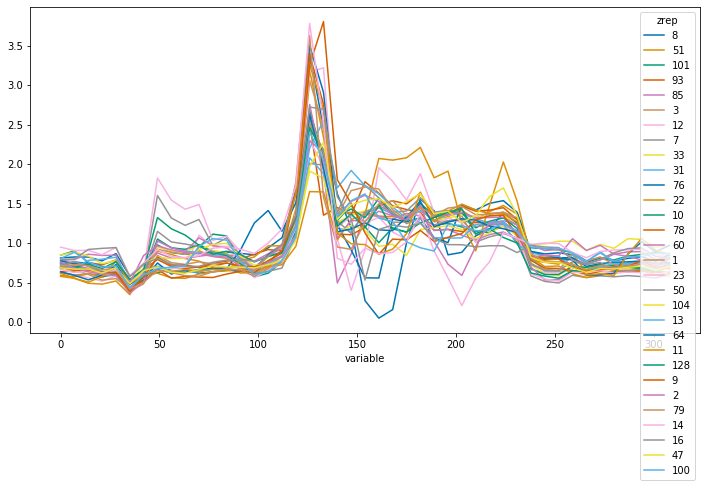

In [83]:
# cluster 1
random.seed(1)
weekly_sales_item_lookup_scaled_clustered.loc[1]\
    .T\
    .iloc[:, random.sample(range(weekly_sales_item_lookup_scaled_clustered.loc[1].shape[0]), weekly_sales_item_lookup_scaled_clustered.loc[1].shape[0])]\
    .plot(figsize = (12,6))

As we can see that Cluster one that the shape of series is captured pretty well , however the fluctuations after day 150 don't seem to be captured that well, it feels like these zreps have some level of variation there that is not captured well.

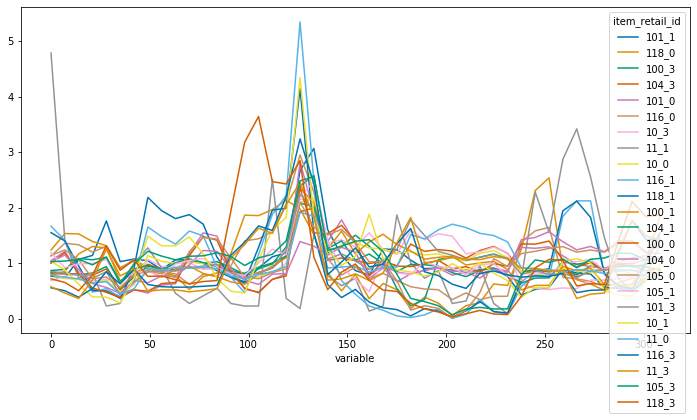

In [93]:
# cluster 2
random.seed(1)
weekly_sales_item_lookup_scaled_clustered.loc[1]\
    .T\
    .iloc[:, random.sample(range(weekly_sales_item_lookup_scaled_clustered.loc[2].shape[0]), weekly_sales_item_lookup_scaled_clustered.loc[2].shape[0])]\
    .plot(figsize = (12,6))

The shape of sries in cluster 2 is similar in terms of the spike between days 120-125, but then it follows a slightly different pattern afterwards, with a bit of a dip immediately after

##### Now let;s try clustering on zrep+retailer level to see if we can get more defined clusters by introducing the additional level of granularity of the retailer

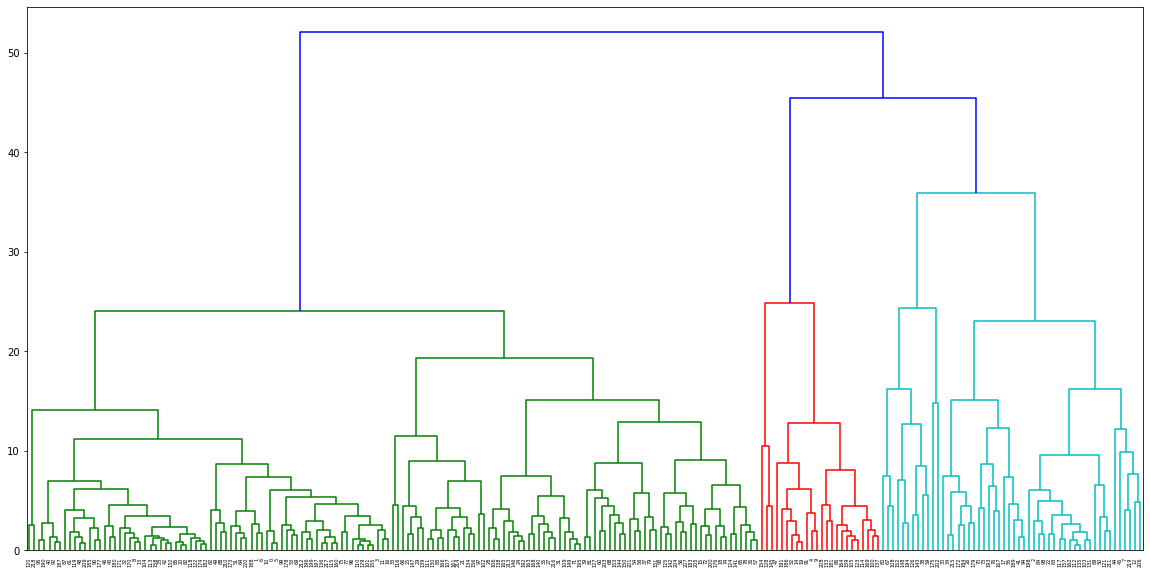

In [85]:
clf = AgglomerativeClustering(n_clusters=None, distance_threshold = 0).fit(daily_sales_itemretail_lookup_scaled.T.values)

distance, weight = get_distances(daily_sales_itemretail_lookup_scaled.T.values,clf)
linkage_matrix = np.column_stack([clf.children_, distance, weight]).astype(float)
plt.figure(figsize=(20,10))
Z= dendrogram(linkage_matrix)
plt.show()

To me this looks to be like the optimal number of clusters is only 3 or 4 clusters as if we draw a line at y=25 and y = 35 for 4 clusters and y = 35 and y = 45 for 3 clusters that is the longest vertical distance where we do not intersect with any other clusters. Let's have a look at the clusters members and what zreps_retailer do we really have in there

In [86]:
 #extract clusters from dendogram
clusters = fcluster(linkage_matrix, 35, criterion='distance')
# create a lookup table for series in a given cluster
weekly_sales_item_lookup_scaled_clustered = daily_sales_itemretail_lookup_scaled.T.reset_index()
weekly_sales_item_lookup_scaled_clustered["cluster"] = clusters
weekly_sales_item_lookup_scaled_clustered = weekly_sales_item_lookup_scaled_clustered.set_index("cluster item_retail_id".split())\
    .sort_index()

weekly_sales_item_lookup_scaled_clustered

Let's examine the clusters that we got

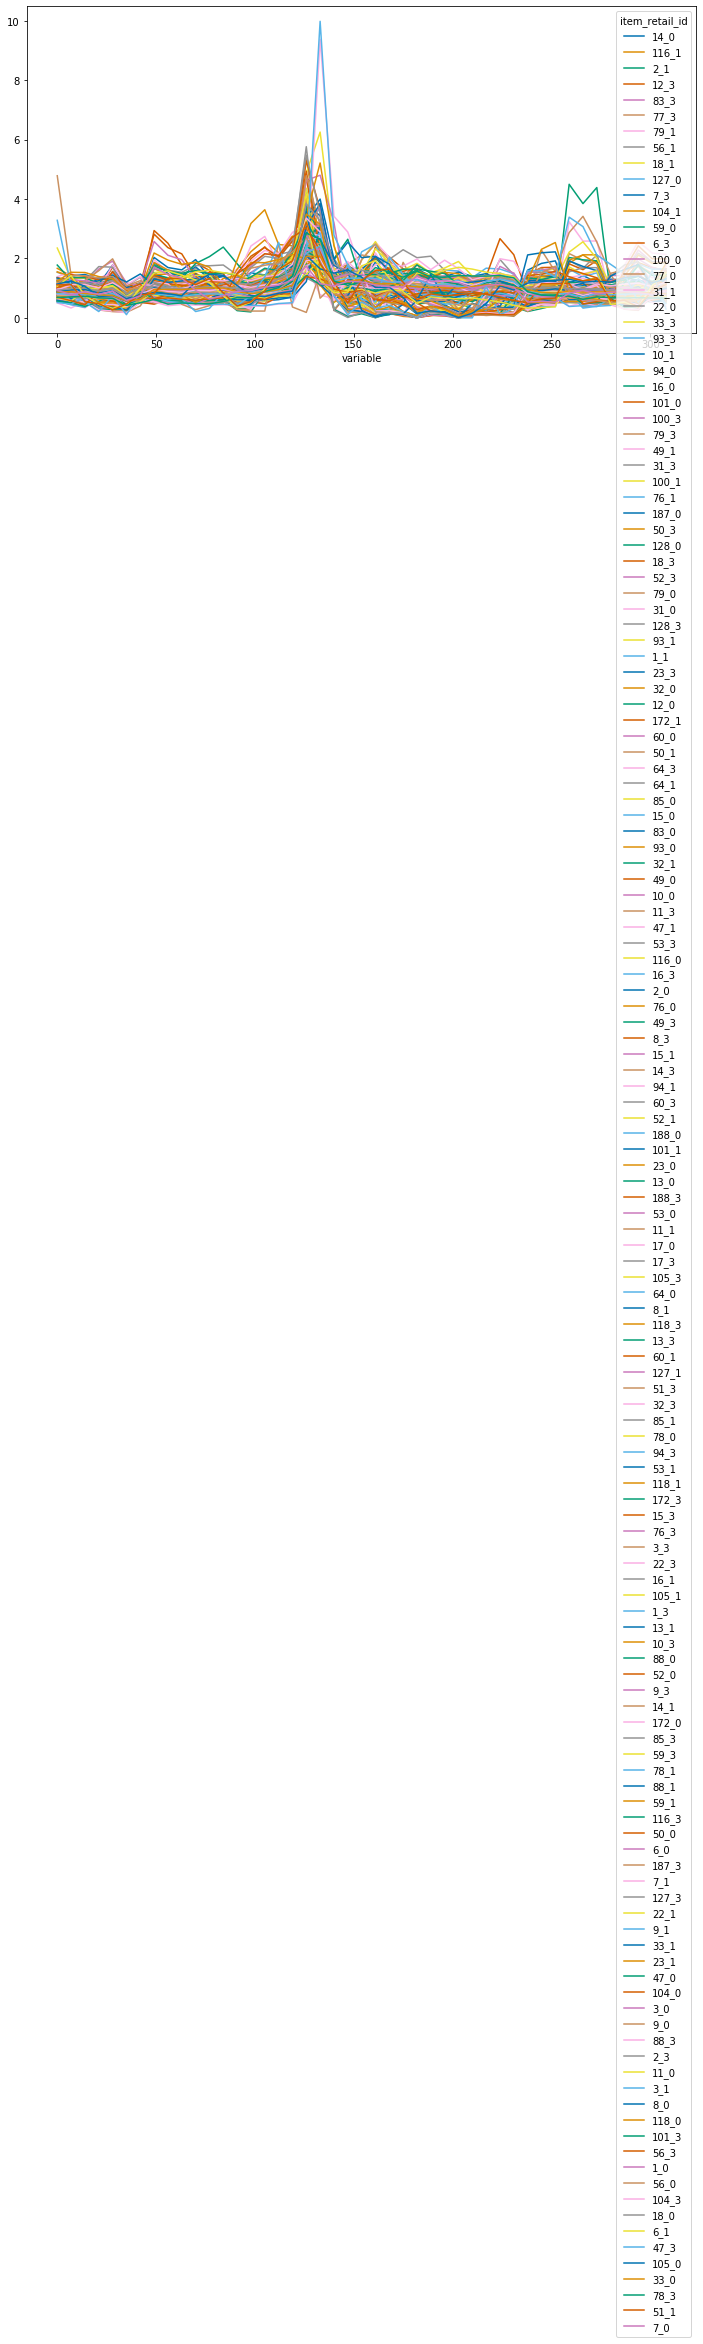

In [87]:
# cluster 1
random.seed(1)
weekly_sales_item_lookup_scaled_clustered.loc[1]\
    .T\
    .iloc[:, random.sample(range(weekly_sales_item_lookup_scaled_clustered.loc[1].shape[0]), weekly_sales_item_lookup_scaled_clustered.loc[1].shape[0])]\
    .plot(figsize = (12,6))

We get a mix of retailer 0,1 and 3 here with a familiar shape of the series that has a spike around day 120-125. Out of interest let's actually check what these days fall onto in terms of the calendar:

In [88]:
startdate = '2019-08-13'
pd.to_datetime(startdate) + pd.DateOffset(days=120)

Timestamp('2019-12-11 00:00:00')

In [89]:
startdate = '2019-08-13'
pd.to_datetime(startdate) + pd.DateOffset(days=140)

Timestamp('2019-12-31 00:00:00')

As suspected, this is a Christmas sales increase where retailers stock up for the holidays , which makes absolute sense

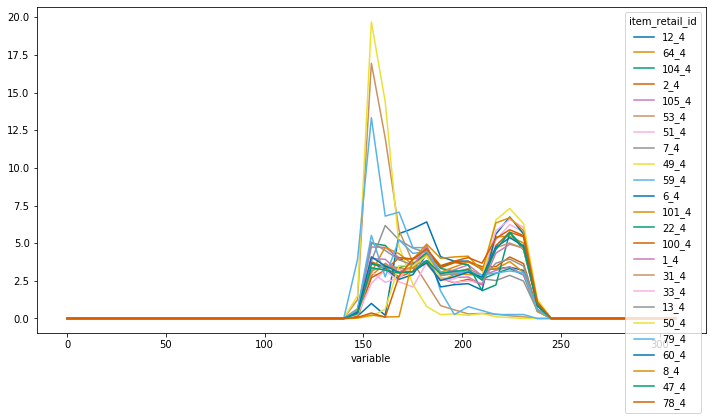

In [90]:
# cluster 2
random.seed(1)
weekly_sales_item_lookup_scaled_clustered.loc[2]\
    .T\
    .iloc[:, random.sample(range(weekly_sales_item_lookup_scaled_clustered.loc[2].shape[0]), weekly_sales_item_lookup_scaled_clustered.loc[2].shape[0])]\
    .plot(figsize = (12,6))

Cluster 2 also has the Xmas spike in demand, however, there is a spike later on around days 220-240  amongst these series that we previously established to be a Covid 19 related fluctuation. We only see retailer 4 being present in this cluster which to me is a signal that this retailer's demand was more affected by the virus than the other retailers

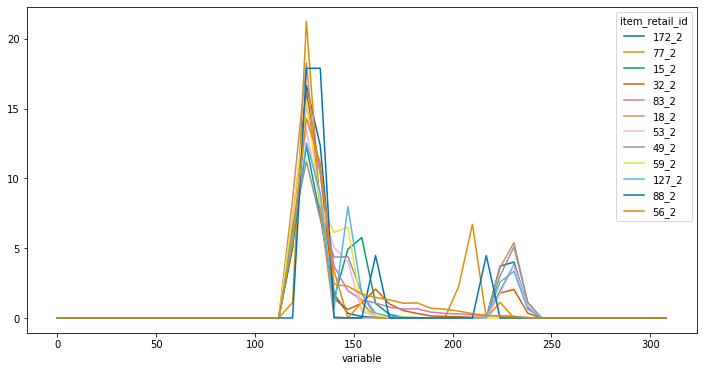

In [91]:
# cluster 3
random.seed(1)
weekly_sales_item_lookup_scaled_clustered.loc[3]\
    .T\
    .iloc[:, random.sample(range(weekly_sales_item_lookup_scaled_clustered.loc[3].shape[0]), weekly_sales_item_lookup_scaled_clustered.loc[3].shape[0])]\
    .plot(figsize = (12,6))

Cluster 3 has only retailer's 2 instances present, with the familiar spike after day 100,then a drop but also a slightly smaller spike around the covid 19 explosion. I would say that this retailer's zreps were somewhere in the middle in terms of the covid 19 effect and it also looks to be a behaviour of a smaller retailer, or a retailer who does not order as much from the supplying company in this example

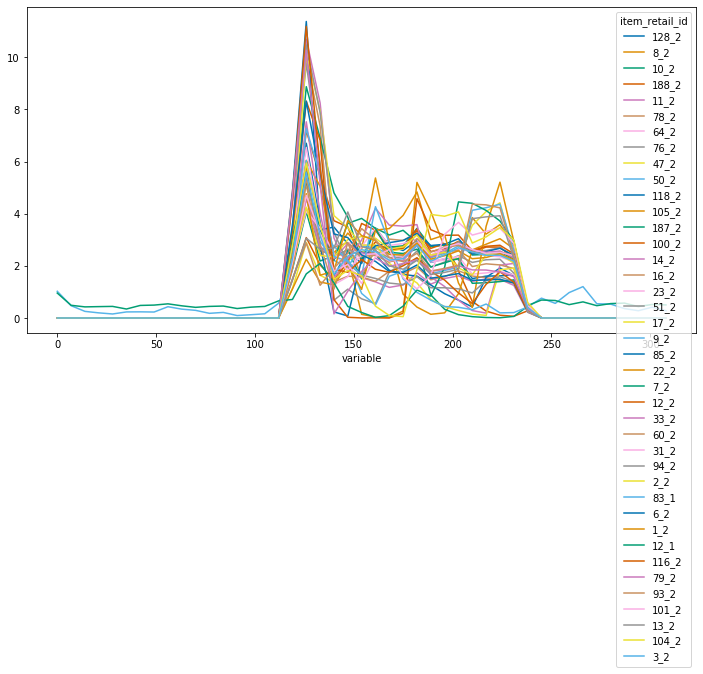

In [92]:
# cluster 4
random.seed(1)
weekly_sales_item_lookup_scaled_clustered.loc[4]\
    .T\
    .iloc[:, random.sample(range(weekly_sales_item_lookup_scaled_clustered.loc[4].shape[0]), weekly_sales_item_lookup_scaled_clustered.loc[4].shape[0])]\
    .plot(figsize = (12,6))

Retailer 2 seems to be mostly represented in the final cluster along with some zreps from retailer 1. These zreps looks to be unaffected by the covid 19 event as they were rather consistent in terms of the sales , which makes me think these might be products that did not fall into the stockpiling category , nor they were the "luxury" products, as we can see the demand consistent across the time.


#### Conclusion and Next steps
* In this notebook, I showed one method we could use to cluster time series: heirarchical clustering using Euclidean distance .
* I tried testing this method on 2 levels of data aggregation- zrep alone and more granular level - zrep+retailer. Both of the datasets were also aggregated on a weekly level in order to get rid of the weekly trends noise.

* My conclusion is that the latter demonstrated clusters that are more defined and also demostrate more meaning behind them once we perform the visual inspection. I suspect this improvement in the clusters definition might be due to the fact that we introduced that additional level of distinction between the zreps that was lacking beforehand

* Some findings :
    * Retailers 0,1 and 3 zreps seems to be behaving in the similar fashion and no significant effect from covid19
    * Retailer's 4 zreps takes its own cluster and has a spike during the covid19 outbreak which leads to think that these products could be falling into the stockpiling-necessity group. 
    * Retailer 2 spans across cluster 3 and 4 but with different zreps. In cluster 3 it seems to be behaving more as a small retailer would, or perhaps someone who does not have a particularly high demand for these products, which signifies that cluster 3 might be capturing more "luxury" items, not a first need products for sure.
    * Cluster 4 is again mostly represented by Retailer's 2 zreps and some of retailer 1. The behaviour in that cluster is more similar to one in cluster 1, but with even higher demand on average. This indicates of items that are consistently "populr", regardless of the covid outbreak. Perhaps items of basic needs that will always be in demand.
    * I would like to say that my initial purpose of this analysis was not to discover the effects of covid19 on the sales demand, but it has been a real discovery and I might take this further and study these effects in more detail
    * I would also like to point out that discovering a Christmas related spike has been an interesting observation. Perhaps if studied in more details then we could discover more even driven spikes, if we take longer time period time series.


* Improvement / Follow Ups:
* As a follow for the futureup, I'd like to mention that analysis like this could help with predictive modelling  . For example: instead of training a model on the entire dataset, it may make sense to train one model per cluster, as the underlying structure of the series' are similar within a cluster. 
* I would also like to mention that next time I would also try different clustering techniques and try obtaining longer time series. 
* Perhaps it could also be worth trying to take daily series in rather thanb goign straight for the weekly.
* It could also be a good idea to cluster on a more granular level such as store level as an example